### CSE2042 Machine Learning
### Deep Belief Network 

Uploading File:-

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving columba.csv to columba.csv


Importing Packages:-

In [ ]:
import tensorflow as tf
from sklearn.metrics import log_loss, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Reading dataset:- 

In [ ]:
df= pd.read_csv('columba.csv')

**Defining Normalization Function :-**

Min-Max Re-scaling: 
Shifting and squeezing a distribution to fit on a scale between 0 and 1. Min-Max Re-scaling is useful for comparing distributions with different scales or different shapes.

In [ ]:
def normalize(x):
  x = x.astype(float)
  min = np.min(x)
  max = np.max(x)
  return (x - min)/(max-min)

**Defining Viewing Function :-**

In [ ]:
def view_values(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([-1,1])
    print(image)

**Dimensions of Dataset Used:-**

In [ ]:
print("Shape of dataframe: ", df.shape)   #train

Shape of dataframe:  (4455, 17)


In [ ]:
df.describe()

,transactionid,ns,nm,nf,entropy,la,ld,lt,fix,ndev,pd,npt,exp,rexp,sexp,bug
count,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000,4455.000000
mean,20755.311111,1.033895,2.723232,6.195062,0.276536,0.240541,0.207428,114.242257,0.328395,3.215039,313.799327,0.811778,5593.237486,2872.446725,4725.505948,0.305499
std,8908.332706,0.244326,7.157377,29.780824,0.377132,0.603062,0.597337,121.745608,0.469682,2.381922,4104.655868,0.284510,5753.802244,2344.544857,5092.376052,0.460670
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.003077,1.000000,1.000000,1.000000,0.000000
25%,14289.500000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,38.000000,0.000000,1.000000,0.000000,0.600000,654.500000,609.375000,510.500000,0.000000
50%,21404.000000,1.000000,1.000000,2.000000,0.000000,0.048363,0.028302,77.000000,0.000000,3.000000,13.000000,1.000000,2784.000000,2784.000000,2061.000000,0.000000
75%,28080.000000,1.000000,2.000000,4.000000,0.666534,0.213538,0.142857,150.000000,1.000000,4.000000,91.000000,1.000000,10253.000000,5132.500000,8392.500000,1.000000
max,35139.000000,6.000000,252.000000,1297.000000,1.000000,21.000000,18.000000,1371.000000,1.000000,15.000000,238874.000000,1.000000,21164.000000,8367.008333,19576.000000,1.000000


Viewing Contents:-

In [ ]:
df.head()

,transactionid,commitdate,ns,nm,nf,entropy,la,ld,lt,fix,ndev,pd,npt,exp,rexp,sexp,bug
0,1,2006/7/8 9:06,1,2,2,0.954434,0.102564,0.102564,39.0,0,1,53,1.0,21140,8343.008333,1188,0
1,6,2006/5/28 22:53,1,3,3,0.693298,0.333333,0.091503,102.0,0,6,24,1.0,70,70.000000,70,0
2,10,2006/5/4 11:48,1,1,1,0.000000,0.097345,0.044248,113.0,1,3,41,1.0,2402,713.716667,2396,0
3,28,2005/9/27 11:09,1,3,4,0.894836,0.035484,0.034409,232.5,0,8,97,1.0,16307,5914.816667,15716,0
4,41,2005/1/24 11:41,1,1,1,0.000000,0.103234,0.004975,804.0,0,4,8,1.0,1778,712.283333,1774,1


In [ ]:
#More visual way to see the values in the layer

def view_gradient(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([14,1])
    plt.title('Example: %d  Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

### RBM

Restricted Boltzmann Machine is an unsupervised learning algorithm.
It has a visible layer of neurons that receives input data which is multiplied by some weights and added to a bias value at the hidden layer neuron to generate output. Then the output value generated at the hidden layer neuron will become a new input which is then multiplied with the same weights and then bias of the visible layer will be added to regenerate input. This process is called reconstruction or backward pass. Then the regenerated input will be compared with the original input if it matches or not. This process will keep on happening until the regenerated input is aligned with the original input.

In [ ]:
# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters:used to control learning process
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate # variables which determine how the network is trained
        self.epochs = epochs #The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work 
                             #through the entire training dataset
        self.batchsize = batchsize #batch size is a hyperparameter that defines the number of samples to work through 
                                   #before updating the internal model parameters.
        
        # Initialize weights and biases using zero matrices
         ##np.zeros:-returns a new array of given shape and type
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)
    # forward pass, where h is the hidden layer and v is the visible layer
       ##Calculate the activation value of the Sigmoid() function from the visible layer to the hidden layer
    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb) #matmul() function returns the matrix product of two arrays
    # backward pass
      ##Calculate the activation value of the Sigmoid() function from the hidden layer to the visible layer
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    # sampling function
      ##Sampling according to the given probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        #A placeholder is simply a variable that we will assign data to at a later date
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)

        ##check
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        #To update the weights, we perform constrastive divergence.
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        # Calculate and update each parameter
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        # We also define the error as the MSE
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X),  self.batchsize),range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch,  _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list
    #function to generate new features from the generative model that the RBM has learned
    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

## Training

In [ ]:
#Droping unnecessary String columns
df=df.drop(['commitdate','transactionid'], axis=1)


###Splitting and Normalizing dataframe

In [ ]:
#split df
train_X = df.iloc[:,:-1].apply(func=normalize, axis=0)
train_Y = df.iloc[:,-1]

In [ ]:
# df=df.drop(['transactionid'], axis=1)
print(df.head())
df.shape

   ns  nm  nf   entropy        la  ...  npt    exp         rexp   sexp  bug
0   1   2   2  0.954434  0.102564  ...  1.0  21140  8343.008333   1188    0
1   1   3   3  0.693298  0.333333  ...  1.0     70    70.000000     70    0
2   1   1   1  0.000000  0.097345  ...  1.0   2402   713.716667   2396    0
3   1   3   4  0.894836  0.035484  ...  1.0  16307  5914.816667  15716    0
4   1   1   1  0.000000  0.103234  ...  1.0   1778   712.283333   1774    1

[5 rows x 15 columns]


(4455, 15)

In [ ]:
inputX = df.iloc[:,:-1].apply(func=normalize, axis=0).values
inputY= df.iloc[:,-1].values
print(type(inputX))
inputX = inputX.astype(np.float32)

#List to hold RBMs
rbm_list = []

#define parameters of RBMs we will train
# 14-20-12-12-2

# def __init__(self, input_size, output_size,learning_rate, epochs, batchsize):
rbm_list.append(RBM(14, 20, 0.002, 200, 100))
rbm_list.append(RBM(20, 12, 0.002, 200, 100))
rbm_list.append(RBM(12, 12, 0.002, 200, 100))

<class 'numpy.ndarray'>


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

In [ ]:
outputList = []
error_list = []

#For each RBM in out list
for i in range(0, len(rbm_list)):
    print('RBM', i+1)
    #Train new RBM
    rbm = rbm_list[i]
    err = rbm.train(inputX)
    error_list.append(err)

    #Return output layer
    #sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)
    outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)
    outputList.append(outputX)
    inputX= hiddenX

RBM 1
Epoch: 0 reconstruction error: 0.415106
Epoch: 1 reconstruction error: 0.383456
Epoch: 2 reconstruction error: 0.358941
Epoch: 3 reconstruction error: 0.337261
Epoch: 4 reconstruction error: 0.319050
Epoch: 5 reconstruction error: 0.303455
Epoch: 6 reconstruction error: 0.291339
Epoch: 7 reconstruction error: 0.278073
Epoch: 8 reconstruction error: 0.267838
Epoch: 9 reconstruction error: 0.257784
Epoch: 10 reconstruction error: 0.253371
Epoch: 11 reconstruction error: 0.244252
Epoch: 12 reconstruction error: 0.239509
Epoch: 13 reconstruction error: 0.230674
Epoch: 14 reconstruction error: 0.226174
Epoch: 15 reconstruction error: 0.222232
Epoch: 16 reconstruction error: 0.219232
Epoch: 17 reconstruction error: 0.217531
Epoch: 18 reconstruction error: 0.211164
Epoch: 19 reconstruction error: 0.207897
Epoch: 20 reconstruction error: 0.206271
Epoch: 21 reconstruction error: 0.200358
Epoch: 22 reconstruction error: 0.197965
Epoch: 23 reconstruction error: 0.198077
Epoch: 24 reconstruc

RBM 1


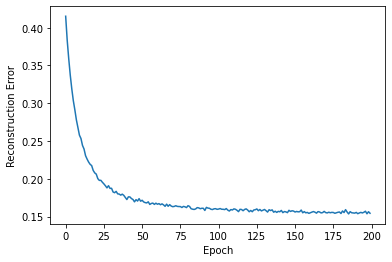

RBM 2


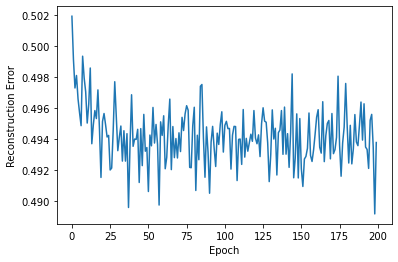

RBM 3


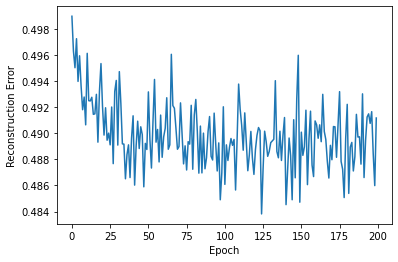

In [ ]:
i = 1
for err in error_list:
    print("RBM",i)
    pd.Series(err).plot(logy=False)
    plt.xlabel("Epoch")
    plt.ylabel("Reconstruction Error")
    plt.show()
    i += 1

In [ ]:
inputX = np.array(train_X)
inputX = inputX.astype(np.float32)
rbmOne = rbm_list[0]

In [ ]:

print('RBM 1')
outputX_rbmOne, reconstructedX_rbmOne, hiddenX_rbmOne = rbmOne.rbm_output(inputX)
reconstructedX_rbmOne = pd.DataFrame(data=reconstructedX_rbmOne, index=train_X.index)
for j in range(0,1):
    example = j
    print("Data generated by First RBM Layer")
    view_values(reconstructedX_rbmOne, train_Y, example)
    print("Original Data")
    view_values(train_X, train_Y, example)

RBM 1
Data generated by First RBM Layer
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Original Data
[[0.00000000e+00]
 [3.98406375e-03]
 [7.71604938e-04]
 [9.54434003e-01]
 [4.88400490e-03]
 [5.69800572e-03]
 [2.84463895e-02]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.21874294e-04]
 [1.00000000e+00]
 [9.98865945e-01]
 [9.97131248e-01]
 [6.06385696e-02]]


In [ ]:
reconstructedX_rbmOne.shape

(4455, 14)

### DBN

A Deep Belief Network (DBN) is a multi-layer generative graphical model. DBNs have bi-directional connections (RBM-type connections) on the top layer while the bottom layers only have top-down connections. They are trained using layerwise pre-training. Pre-training occurs by training the network component by component bottom up: treating the first two layers as an RBM and training, then treating the second layer and third layer as another RBM and training for those parameters.

In [ ]:
class DBN(object):
    def __init__(self, original_input_size, input_size, output_size, 
                 learning_rate, epochs, batchsize, rbmOne, rbmTwo, rbmThree):
        # Define hyperparameters
        self._original_input_size = original_input_size
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        self.rbmOne = rbmOne
        self.rbmTwo = rbmTwo
        self.rbmThree = rbmThree
    
        self.w = np.zeros([input_size, output_size], "float")
        self.hb = np.zeros([output_size], "float")
        self.vb = np.zeros([input_size], "float")
    
    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], "float")
        prv_hb = np.zeros([self._output_size], "float")
        prv_vb = np.zeros([self._input_size], "float")
        
        cur_w = np.zeros([self._input_size, self._output_size], "float")
        cur_hb = np.zeros([self._output_size], "float")
        cur_vb = np.zeros([self._input_size], "float")
        
        v0 = tf.placeholder("float", [None, self._original_input_size])

        forwardOne = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(v0, self.rbmOne.w) + self.rbmOne.hb) - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul(v0, self.rbmOne.w) + self.rbmOne.hb)))))
        forwardTwo = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(forwardOne, self.rbmTwo.w) + self.rbmTwo.hb) - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul(forwardOne, self.rbmTwo.w) + self.rbmTwo.hb)))))
        forward = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(forwardTwo, self.rbmThree.w) + self.rbmThree.hb) - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul( forwardTwo, self.rbmThree.w) + self.rbmThree.hb)))))
        h0 = self.sample_prob(self.prob_h_given_v(forward, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(forward), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(forward)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(forward - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        backwardOne = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(v1, self.rbmThree.w.T) + self.rbmThree.vb) - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul(v1, self.rbmThree.w.T) + self.rbmThree.vb)))))
        backwardTwo = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(backwardOne, self.rbmTwo.w.T) + self.rbmTwo.vb) - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul(backwardOne, self.rbmTwo.w.T) + self.rbmTwo.vb)))))
        backward = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(backwardTwo, self.rbmOne.w.T) + self.rbmOne.vb) - tf.random_uniform(tf.shape(tf.nn.sigmoid(tf.matmul(backwardTwo, self.rbmOne.w.T) + self.rbmOne.vb)))))
        
        err = tf.reduce_mean(tf.square(v0 - backward))
        error_list = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w:  prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % (epoch+1),'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list
        
    def dbn_output(self, X):

        input_X = tf.constant(X)
        forwardOne = tf.nn.sigmoid(tf.matmul(input_X, self.rbmOne.w) + self.rbmOne.hb)
        forwardTwo = tf.nn.sigmoid(tf.matmul(forwardOne, self.rbmTwo.w) + self.rbmTwo.hb)
        forward = tf.nn.sigmoid(tf.matmul(forwardTwo, self.rbmThree.w) + self.rbmThree.hb)

        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)

        out = tf.nn.sigmoid(tf.matmul(forward, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(forward, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))

        backwardTwo = tf.nn.sigmoid(tf.matmul(visibleGen, self.rbmThree.w.T) + self.rbmThree.vb)
        backwardOne = tf.nn.sigmoid(tf.matmul(backwardTwo, self.rbmTwo.w.T) + self.rbmTwo.vb)
        backward = tf.nn.sigmoid(tf.matmul(backwardOne, self.rbmOne.w.T) + self.rbmOne.vb)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(backward)

def __init__(self, original_input_size, input_size, output_size, 
                 learning_rate, epochs, batchsize, rbmOne, rbmTwo, rbmThree):

In [ ]:
dbn = DBN(14, 12, 12, 0.02, 50, 100, rbm_list[0], rbm_list[1], rbm_list[2])

In [ ]:
inputX = np.array(inputX)
error_list = []
error_list = dbn.train(inputX)

Epoch: 1 reconstruction error: 0.155458
Epoch: 2 reconstruction error: 0.154670
Epoch: 3 reconstruction error: 0.154400
Epoch: 4 reconstruction error: 0.156037
Epoch: 5 reconstruction error: 0.156396
Epoch: 6 reconstruction error: 0.156438
Epoch: 7 reconstruction error: 0.155375
Epoch: 8 reconstruction error: 0.156715
Epoch: 9 reconstruction error: 0.158173
Epoch: 10 reconstruction error: 0.155541
Epoch: 11 reconstruction error: 0.153878
Epoch: 12 reconstruction error: 0.156690
Epoch: 13 reconstruction error: 0.156560
Epoch: 14 reconstruction error: 0.155136
Epoch: 15 reconstruction error: 0.157526
Epoch: 16 reconstruction error: 0.157989
Epoch: 17 reconstruction error: 0.155396
Epoch: 18 reconstruction error: 0.154696
Epoch: 19 reconstruction error: 0.156323
Epoch: 20 reconstruction error: 0.153819
Epoch: 21 reconstruction error: 0.155798
Epoch: 22 reconstruction error: 0.158309
Epoch: 23 reconstruction error: 0.156548
Epoch: 24 reconstruction error: 0.157052
Epoch: 25 reconstruction 

DBN


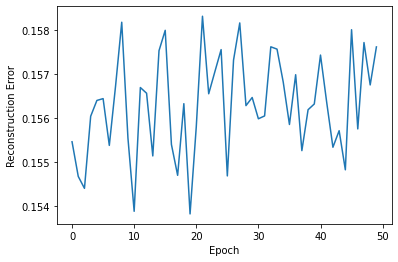

In [ ]:
print("DBN")
pd.Series(error_list).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")
plt.show()

In [ ]:
train_X.shape
train_Y.head

<bound method NDFrame.head of 0       0
1       0
2       0
3       0
4       1
       ..
4450    1
4451    0
4452    1
4453    0
4454    0
Name: bug, Length: 4455, dtype: int64>

TESTING



In [ ]:
train_X.shape
# train_Y.shape

(4455, 14)

In [ ]:
print('DBN 1')
outputX_dbn, reconstructedX_dbn = dbn.dbn_output(inputX)

DBN 1


###**Classifier**(Logistic)


Used outputX_dbn as the Input for the Classifer

In [ ]:
Y_Train = train_Y.iloc[:4000].values
Y_Train.shape

(4000,)

Logistic Regression

In [ ]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def hypothesis(X, theta) :
    #returns the dot product of vectors X and theta
    return sigmoid(np.dot(X, theta))

def error(X,y,theta):
    hi = hypothesis(X,theta)
    error= -1* np.mean ( y * np.log(hi) + ( ( 1 - y ) * (np.log( 1 - hi )) ) )

    return error

In [ ]:
def gradient(X,y,theta):
    hi = hypothesis(X,theta)
    #X.T :transpose of X
    grad = np.dot(X.T,(y-hi))
    m=X.shape[0]

    return grad/m

def gradient_descent(X,y,lr=0.02,max_itr=500):
    
    n=X.shape[1] 
    theta = np.zeros((n,1))
    
    error_list= []
    
    for i in range(max_itr):
        err = error(X,y,theta)
        error_list.append(err)

        grad = gradient(X,y,theta)
        #update theta
        theta = theta + lr * grad
    return (theta, error_list)

In [ ]:
ones = np.ones((outputX_dbn.shape[0],1))
X_New_Train = np.hstack((ones,outputX_dbn))
X_New_Train = X_New_Train[:4000,:]
Y_Train= Y_Train.reshape((-1,1))

In [ ]:
Y_Train.shape

(4000, 1)

In [ ]:
theta, error_list = gradient_descent(X_New_Train, Y_Train)

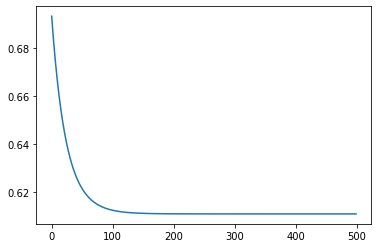

In [ ]:
plt.plot(error_list)

In [ ]:
theta.shape

(13, 1)

In [ ]:
print(theta)

[[-0.19467426]
 [-0.10421404]
 [-0.09983098]
 [-0.10197391]
 [-0.10044319]
 [-0.10766178]
 [-0.10890671]
 [-0.09025086]
 [-0.09504226]
 [-0.10511877]
 [-0.12076287]
 [-0.09634728]
 [-0.10101034]]


In [ ]:
def predict(X,theta):
    h = hypothesis(X, theta)
    output = np.zeros(h.shape)
    output[h>=0.5] = 1
    output = output.astype('int')
    return output

XT_preds = predict(X_New_Train,theta)

Predict

In [ ]:
print(XT_preds)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [ ]:
def accuracy(actual, preds):

    actual = actual.astype('int')
    actual = actual.reshape((-1,1))

    acc= np.sum(actual==preds)/actual.shape[0]

    return acc*100

### Accuracy

In [ ]:
train_acc= accuracy(Y_Train,XT_preds)
print(train_acc)

70.0


### Evaluation Metrics

In [ ]:
 from sklearn.metrics import f1_score
 from sklearn.metrics import recall_score
 from sklearn.metrics import precision_score

In [ ]:
print(f1_score(Y_Train,XT_preds,average='micro'))

0.7
